In [1]:
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import numpy as np
import scipy.sparse as sp
from pytorchtools import EarlyStopping

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [30]:
ratings_title = ['UserID','MovieID', 'Rating', 'timestamps']
ratings = pd.read_table('./ml-1m/ratings.dat', sep='::', header=None, names=ratings_title, engine = 'python')
ratings.head()

,UserID,MovieID,Rating,timestamps
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [5]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler

ratings['Rating'] = MinMaxScaler().fit_transform(ratings['Rating'].values.reshape(-1,1))
ratings.head()

,UserID,MovieID,Rating,timestamps
0,1,1193,1.00,978300760
1,1,661,0.50,978302109
2,1,914,0.50,978301968
3,1,3408,0.75,978300275
4,1,2355,1.00,978824291


In [2]:
def load_data(num):
    """
    Load Dataset from File
    """
    #读取电影数据集
    movies_title = ['MovieID', 'Title', 'Genres']
    movies = pd.read_table('./ml-1m/movies.dat', sep='::', header=None, 
                       names=movies_title,engine='python',encoding='ISO-8859-1')
    
    #读取评分数据集
    ratings_title = ['UserID','MovieID', 'ratings', 'timestamps']
    ratings_all = pd.read_table('./ml-1m/ratings.dat', sep='::', header=None, names=ratings_title, engine = 'python')
    ## 抽取部分数据(不重复选取)
    sap = random.sample(list(set(ratings_all['UserID'])),num)
    ratings = ratings_all[ratings_all['UserID'].isin(sap)].reset_index()
    
    ratings = ratings.filter(regex='UserID|MovieID|ratings')
    ratings_orig = ratings.copy()
    
    ## 将userid编号从0开始
    userid_set = set(ratings['UserID'].unique())

    userid2int = {val:i for i,val in enumerate(userid_set)}
    ratings['UserID'] = ratings['UserID'].map(userid2int)
    
    ## 将movies数据集中电影的ID编码从0开始
    movieid_set = set(movies['MovieID'].unique())
    
    movieid2int = {val:i for i,val in enumerate(movieid_set)}
    ratings['MovieID'] = ratings['MovieID'].map(movieid2int)
    
    ## 获取user对应的items的字典
    new_user = set(ratings['UserID'].unique())
    user_item_dict = {val:list(ratings.loc[ratings['UserID']==val,'MovieID']) for val in new_user}
    
#     ratings['Rating'] = MinMaxScaler().fit_transform(ratings['Rating'].values.reshape(-1,1))
    
    ## 读取User特征数据集
#     users = pd.read_table('./ml-1m/users.dat', sep='::', header=None, names=users_title, engine = 'python')
#     users = users.filter(regex='UserID|Gender|Age|JobID')
    
    #将数据分成X和y两张表
    target_fields = ['ratings']
    features_pd, targets_pd = ratings.drop(target_fields, axis=1), ratings[target_fields]
    
    features = features_pd.values
    targets_values = targets_pd.values
    
    return user_item_dict,features_pd,userid2int,movieid2int,ratings_all,movies

In [3]:
## 对数据进行采样
def sample(n_items,exist_users,user_item_dict,batch_size):
    if batch_size <= len(exist_users):
        users = random.sample(exist_users, batch_size)
    else:
        users = [random.choice(exist_users) for _ in range(batch_size)]

    def sample_pos_items_for_u(u, num):
        # sample num pos items for u-th user
        pos_items = user_item_dict[u]
        n_pos_items = len(pos_items)
        pos_batch = []
        while True:
            if len(pos_batch) == num:
                break
            pos_id = np.random.randint(low=0, high=n_pos_items, size=1)[0]
            pos_i_id = pos_items[pos_id]

            if pos_i_id not in pos_batch:
                pos_batch.append(pos_i_id)
        return pos_batch

    def sample_neg_items_for_u(u, num):
        # sample num neg items for u-th user
        neg_items = []
        while True:
            if len(neg_items) == num:
                break
            neg_id = np.random.randint(low=0, high=n_items,size=1)[0]
            if neg_id not in user_item_dict[u] and neg_id not in neg_items:
                neg_items.append(neg_id)
        return neg_items

    pos_items, neg_items = [], []
    for u in users:
        pos_items += sample_pos_items_for_u(u, 1)
        neg_items += sample_neg_items_for_u(u, 1)

    return users, pos_items, neg_items

## 构建图神经网络

In [4]:
class NGCF(nn.Module):
    def __init__(self, n_user, n_item, norm_adj,emb_size,batch_size):
        super(NGCF, self).__init__()
        self.n_user = n_user
        self.n_item = n_item
        self.emb_size = emb_size
        self.batch_size = batch_size
        self.node_dropout = 0.1

        self.norm_adj = norm_adj
        self.layers = [64,64,64]
        self.decay = 1e-5
        
        """
        *********************************************************
        Init the weight of user-item.
        """
        self.embedding_dict, self.weight_dict = self.init_weight()

        """
        *********************************************************
        Get sparse adj.
        """
        self.sparse_norm_adj = self._convert_sp_mat_to_sp_tensor(self.norm_adj)

    def init_weight(self):
        # xavier init
        initializer = nn.init.xavier_uniform_

        embedding_dict = nn.ParameterDict({
            'user_emb': nn.Parameter(initializer(torch.empty(self.n_user,
                                                 self.emb_size))),
            'item_emb': nn.Parameter(initializer(torch.empty(self.n_item,
                                                 self.emb_size)))
        })

        weight_dict = nn.ParameterDict()
        layers = [self.emb_size] + self.layers
        for k in range(len(self.layers)):
            weight_dict.update({'W_gc_%d'%k: nn.Parameter(initializer(torch.empty(layers[k],
                                                                      layers[k+1])))})
            weight_dict.update({'b_gc_%d'%k: nn.Parameter(initializer(torch.empty(1, layers[k+1])))})

            weight_dict.update({'W_bi_%d'%k: nn.Parameter(initializer(torch.empty(layers[k],
                                                                      layers[k+1])))})
            weight_dict.update({'b_bi_%d'%k: nn.Parameter(initializer(torch.empty(1, layers[k+1])))})

        return embedding_dict, weight_dict

    def _convert_sp_mat_to_sp_tensor(self, X):
        coo = X.tocoo()
        i = torch.LongTensor([coo.row, coo.col])
        v = torch.from_numpy(coo.data).float()
        return torch.sparse.FloatTensor(i, v, coo.shape)

    def sparse_dropout(self, x, rate, noise_shape):
        random_tensor = 1 - rate
        random_tensor += torch.rand(noise_shape)
        dropout_mask = torch.floor(random_tensor).type(torch.bool)
        i = x._indices()
        v = x._values()

        i = i[:, dropout_mask]
        v = v[dropout_mask]

        out = torch.sparse.FloatTensor(i, v, x.shape)
        return out * (1. / (1 - rate))

    def create_bpr_loss(self, users, pos_items, neg_items):
        pos_scores = torch.sum(torch.mul(users, pos_items), axis=1)#按行求和,维度为1的去掉
        neg_scores = torch.sum(torch.mul(users, neg_items), axis=1)

        maxi = nn.LogSigmoid()(pos_scores - neg_scores)

        mf_loss = -1 * torch.mean(maxi)

        # cul regularizer
        regularizer = (torch.norm(users) ** 2
                       + torch.norm(pos_items) ** 2
                       + torch.norm(neg_items) ** 2) / 2
        emb_loss = self.decay * regularizer / self.batch_size

        return mf_loss + emb_loss, mf_loss, emb_loss

    def rating(self, u_g_embeddings, pos_i_g_embeddings):
        return torch.matmul(u_g_embeddings, pos_i_g_embeddings.t())

    def forward(self, users, pos_items, neg_items,drop_flag=True):

        A_hat = self.sparse_dropout(self.sparse_norm_adj,
                                    self.node_dropout,
                                    self.sparse_norm_adj._nnz()) if drop_flag else self.sparse_norm_adj
        #A_hat = self.sparse_norm_adj
        ego_embeddings = torch.cat([self.embedding_dict['user_emb'],
                                    self.embedding_dict['item_emb']], 0)

        all_embeddings = [ego_embeddings]

        for k in range(len(self.layers)):
            side_embeddings = torch.sparse.mm(A_hat, ego_embeddings)

            # transformed sum messages of neighbors.
            sum_embeddings = torch.matmul(side_embeddings, self.weight_dict['W_gc_%d' % k]) \
                                             + self.weight_dict['b_gc_%d' % k]

            # bi messages of neighbors.
            # element-wise product
            bi_embeddings = torch.mul(ego_embeddings, side_embeddings)
            # transformed bi messages of neighbors.
            bi_embeddings = torch.matmul(bi_embeddings, self.weight_dict['W_bi_%d' % k]) \
                                            + self.weight_dict['b_bi_%d' % k]

            # non-linear activation.
            ego_embeddings = nn.LeakyReLU(negative_slope=0.2)(sum_embeddings + bi_embeddings)

            # message dropout.
            ego_embeddings = nn.Dropout(0.4)(ego_embeddings)

            # normalize the distribution of embeddings.
            norm_embeddings = F.normalize(ego_embeddings, p=2, dim=1)##按行进行操作

            all_embeddings += [norm_embeddings]

        all_embeddings = torch.cat(all_embeddings, 1) #按列拼接
        u_g_embeddings = all_embeddings[:self.n_user, :]
        i_g_embeddings = all_embeddings[self.n_user:, :]

        """
        *********************************************************
        look up.
        """
        u_g_embeddings = u_g_embeddings[users, :]
        pos_i_g_embeddings = i_g_embeddings[pos_items, :]
        neg_i_g_embeddings = i_g_embeddings[neg_items, :]

        return u_g_embeddings, pos_i_g_embeddings, neg_i_g_embeddings

## 构建邻接矩阵

In [5]:
from time import time
def create_adj_mat(n_users,n_items):
    t1 = time()
    adj_mat = sp.dok_matrix((n_users + n_items, n_users + n_items), dtype=np.float32)
    adj_mat = adj_mat.tolil()
    R = sp.dok_matrix((n_users, n_items), dtype=np.float32)
    R = R.tolil()

    adj_mat[:n_users, n_users:] = R
    adj_mat[n_users:, :n_users] = R.T
    adj_mat = adj_mat.todok()
    print('already create adjacency matrix', adj_mat.shape, time() - t1)

    t2 = time()

    def mean_adj_single(adj):
        # D^-1 * A
        rowsum = np.array(adj.sum(1))

        d_inv = np.power(rowsum, -1).flatten()
        d_inv[np.isinf(d_inv)] = 0.
        d_mat_inv = sp.diags(d_inv)

        norm_adj = d_mat_inv.dot(adj)
        # norm_adj = adj.dot(d_mat_inv)
        print('generate single-normalized adjacency matrix.')
        return norm_adj.tocoo()

    def normalized_adj_single(adj):
        # D^-1/2 * A * D^-1/2
        rowsum = np.array(adj.sum(1))

        d_inv_sqrt = np.power(rowsum, -0.5).flatten()
        d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
        d_mat_inv_sqrt = sp.diags(d_inv_sqrt)

        # bi_lap = adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt)
        bi_lap = d_mat_inv_sqrt.dot(adj).dot(d_mat_inv_sqrt)
        return bi_lap.tocoo()

    def check_adj_if_equal(adj):
        dense_A = np.array(adj.todense())
        degree = np.sum(dense_A, axis=1, keepdims=False)

        temp = np.dot(np.diag(np.power(degree, -1)), dense_A)
        print('check normalized adjacency matrix whether equal to this laplacian matrix.')
        return temp

    norm_adj_mat = mean_adj_single(adj_mat + sp.eye(adj_mat.shape[0]))
    # norm_adj_mat = normalized_adj_single(adj_mat + sp.eye(adj_mat.shape[0]))
    mean_adj_mat = mean_adj_single(adj_mat)

    print('already normalize adjacency matrix', time() - t2)
    return adj_mat.tocsr(), norm_adj_mat.tocsr(), mean_adj_mat.tocsr()

In [6]:
## 加载数据
num =2000 #抽取num个用户
user_item_dict,features_pd,userid2int,movieid2int,ratings_all,movies = load_data(num)
n_users = len(features_pd['UserID'].unique())
exist_users = list(features_pd['UserID'].unique())
n_items = len(list(movieid2int.keys()))
print(f'n_users:{n_users},n_items:{n_items}')
## 获得邻接矩阵
adj_mat, norm_adj_mat, mean_adj_mat = create_adj_mat(n_users,n_items)

n_users:2000,n_items:3883
already create adjacency matrix (5883, 5883) 0.569040060043335
generate single-normalized adjacency matrix.
generate single-normalized adjacency matrix.
already normalize adjacency matrix 0.010032176971435547


C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_1940/1474211729.py:20: RuntimeWarning: divide by zero encountered in power
  d_inv = np.power(rowsum, -1).flatten()


In [8]:
## 参数设置
emb_size = 64
batch_size = 128
n_batch = n_users // batch_size + 1
learning_rate = 1e-3
epochs = 200 

patience = 10 
early_stopping = EarlyStopping(patience, verbose=True) 

## 模型训练

In [9]:
loss_list = []
model = NGCF(n_users,n_items,norm_adj_mat,emb_size,batch_size)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
model.train()

for epoch in range(epochs):
    loss = 0.
    exist_users_copy = exist_users.copy()
    for n in range(n_batch):
        users, pos_items, neg_items = sample(n_items,exist_users_copy,user_item_dict,batch_size)
        u_g_embeddings, pos_i_g_embeddings, neg_i_g_embeddings = model(users, pos_items, neg_items)
        batch_loss, batch_mf_loss, batch_emb_loss = model.create_bpr_loss(u_g_embeddings,
                                                                              pos_i_g_embeddings,
                                                                              neg_i_g_embeddings)
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
        loss += batch_loss
        exist_users_copy = list(set(exist_users_copy)-set(users))#去除当前训练的用户
    
    loss_list.append(loss/n_batch)
    if (epoch+1)%10 == 0:
        print('Epoch:%d,loss: %.5f'%(epoch+1,loss/n_batch))

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_1940/1712057816.py:52: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:210.)
  i = torch.LongTensor([coo.row, coo.col])


Epoch:10,loss: 0.70041
Epoch:20,loss: 0.68072
Epoch:30,loss: 0.49628
Epoch:40,loss: 0.46074
Epoch:50,loss: 0.41687
Epoch:60,loss: 0.39913
Epoch:70,loss: 0.40027
Epoch:80,loss: 0.39067
Epoch:90,loss: 0.39226
Epoch:100,loss: 0.39172
Epoch:110,loss: 0.36938
Epoch:120,loss: 0.37469
Epoch:130,loss: 0.35555
Epoch:140,loss: 0.36503
Epoch:150,loss: 0.33816
Epoch:160,loss: 0.33987
Epoch:170,loss: 0.35748
Epoch:180,loss: 0.36101
Epoch:190,loss: 0.33163
Epoch:200,loss: 0.33105


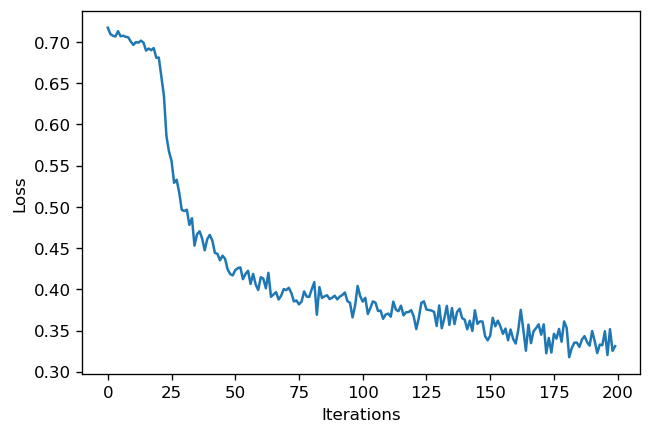

In [27]:
import matplotlib.pyplot as plt

loss_lst = [i.item() for i in loss_list]
plt.figure(dpi=120)
x = range(len(loss_lst))
plt.plot(x,loss_lst)

plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [11]:
### 保存模型
# torch.save(model,'./model.pkl')
### 加载模型
if '__main__' == '__name__':
    model = torch.load('./model.pkl')

## 预测

In [28]:
def prediction(model,ratings,movieid2int,userid2int,users,k):
    rec_movie_dict = {}
    rec_movie_dict['UserID'] = users
    Watch_MovieID, Recommender_MovieID,ui_ratings = [],[],[]
    for user in users: 
        ### 得到users所评分的电影
        movies_pos_orig = ratings[ratings.UserID.isin([int(user)])]['MovieID']
        #print(f'UserID:{users+1}看过的电影为:\n{list(movies_pos_orig)}')
        Watch_MovieID.append(list(movies_pos_orig))
        movies_pos = list(movies_pos_orig.map(movieid2int))
        
        ### 得到users未评分的电影
        movies_negdata = ratings[~ratings.MovieID.isin(list(movies_pos_orig))]
        movies_neg = list(set((movies_negdata['MovieID'].map(movieid2int))))
        ### 对user编码
        user = userid2int[user]
        
        model.eval()
        u_embeddings, _ , neg_i_embeddings = model(user,[],movies_neg) 
        u_i_ratings = torch.sum(torch.mul(u_embeddings,neg_i_embeddings),axis=1)
        indx = list(torch.sort(u_i_ratings,descending=True).indices.numpy())[:k] #sort默认升序
        #print(f'前{k}个电影得分的索引位置{indx}')
        ui_ratings.append(list(u_i_ratings[indx].detach().numpy()))
        
        rec_movie = [movies_neg[i] for i in indx]
        movieid_valarr = np.array(list(movieid2int.values()))
        movieid_keyarr = np.array(list(movieid2int.keys()))
        rec_movie = list(movieid_keyarr[np.where(movieid_valarr==np.array(rec_movie)[:,None])[-1]])
        
        Recommender_MovieID.append(rec_movie) 
        #print(f'给UserID:{users+1}推荐的电影为:{rec_movie}')
    
    rec_movie_dict['Watch_MovieID'] = Watch_MovieID
    rec_movie_dict['Recommender_MovieID'] = Recommender_MovieID
    rec_movie_dict['ui_ratings'] = ui_ratings
    
    return rec_movie_dict

In [29]:
## 在除去训练集2000个user中,随机选取1000个user进行测试
def test_sample(test_num,k):
    train_user = list(userid2int.keys())
    test_ratings_orig = ratings_all[~ratings_all.UserID.isin(train_user)]
    sample = random.sample(list(set(test_ratings_orig['UserID'])),test_num)
    test_ratings = test_ratings_orig[test_ratings_orig.UserID.isin(sample)]

    test_user_set = set(test_ratings['UserID'])
    test_userid2int = {val:i for i,val in enumerate(test_user_set)}

    test_user_list = list(test_user_set)
    rec_movie_dict = prediction(model,ratings_all,movieid2int,test_userid2int,test_user_list,k)
    
    return rec_movie_dict

In [31]:
test_num = 10
k = 10
rec_movie_dict = test_sample(test_num,k)
rec_movie = pd.DataFrame(rec_movie_dict)
rec_movie

,UserID,Watch_MovieID,Recommender_MovieID,ui_ratings
0,3814,"[3044, 1625, 3263, 3635, 3638, 3639, 3640, 364...","[1210, 260, 2571, 589, 608, 1270, 858, 2396, 2...","[3.8776906, 3.7342732, 3.6859384, 3.626208, 3...."
1,5448,"[2057, 586, 587, 1, 1408, 2065, 1409, 2067, 59...","[1210, 1259, 318, 593, 1580, 1097, 2987, 2997,...","[2.8417337, 2.7553642, 2.699039, 2.6301143, 2...."
2,1872,"[1249, 573, 1256, 1259, 1269, 593, 3022, 908, ...","[1210, 2997, 2858, 1196, 260, 1270, 2028, 318,...","[4.078373, 3.7611318, 3.7606936, 3.7175667, 3...."
3,1968,"[2987, 715, 1249, 3932, 3937, 2054, 2058, 2997...","[260, 912, 858, 1214, 1387, 2918, 3897, 1265, ...","[3.007581, 2.8785424, 2.7854102, 2.7825298, 2...."
4,4464,"[3791, 593, 920, 955, 248, 3801, 3809, 3834, 3...","[1210, 2858, 1196, 2997, 2762, 260, 110, 1036,...","[3.467898, 3.408966, 3.3283818, 3.2487774, 3.2..."
5,4595,"[589, 1, 593, 595, 596, 3019, 908, 912, 919, 9...","[2858, 1210, 2959, 2762, 3578, 356, 2396, 457,...","[2.8476555, 2.7293768, 2.6205142, 2.5961235, 2..."
6,20,"[648, 3863, 589, 1694, 2641, 1912, 2571, 3527,...","[2762, 260, 480, 1127, 1210, 1196, 1265, 1, 11...","[3.0021338, 2.8844342, 2.7907052, 2.776576, 2...."
7,438,"[2987, 719, 2053, 3793, 2054, 720, 2058, 1256,...","[1035, 788, 317, 1307, 913, 3418, 590, 2881, 1...","[2.2055602, 2.1940956, 2.1656892, 2.1628408, 2..."
8,121,"[3934, 1320, 1253, 1, 1265, 1196, 1198, 594, 1...","[589, 2858, 1240, 2028, 480, 593, 608, 2000, 8...","[3.3688164, 3.1499262, 3.1209085, 3.0617697, 2..."
9,5882,"[2058, 589, 924, 968, 2455, 3471, 260, 610, 11...","[608, 3176, 2706, 1208, 785, 1269, 440, 235, 3...","[2.9281287, 2.8423734, 2.7881994, 2.6067586, 2..."
